# Welcome to the Megaline Mobile Carrier Project

In this endeavor, Megaline aims to modernize its service by offering personalized plan recommendations to subscribers based on their behavior. Leveraging behavioral data from subscribers who've migrated to newer plans, the task involves crafting a model capable of suggesting either the Smart or Ultra plans.

- The objective: crafting a high-accuracy model, targeting the 0.75 accuracy threshold using the provided test dataset.
- The roadmap includes data split into training, validation, and test sets, exploring varied model configurations via hyperparameter adjustments, and robust model performance evaluations.
- Additionally, there's a challenge: sanity checking the model's robustness against the dataset's complexity.
- Each dataset entry covers monthly user behavior, encompassing call frequency, call duration, text messages, internet usage (in MB), and plan type (Ultra - 1, Smart - 0).

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.metrics import roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

#classifiers to use
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier

## Data loading and overview

In [40]:
# source 'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/users_behavior.csv'
users = pd.read_csv('users_behavior.csv')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [41]:
print('Descriptive stats for the whole dataset')
display(users.describe().T.style.format('{:.2f}'))
print('Descriptive stats for the Ultra users')
display(users[users['is_ultra'] == 1].describe().T.style.format('{:.2f}'))
print('Descriptive stats for the Smart users')
display(users[users['is_ultra'] == 0].describe().T.style.format('{:.2f}'))

Descriptive stats for the whole dataset


,count,mean,std,min,25%,50%,75%,max
calls,3214.00,63.04,33.24,0.00,40.00,62.00,82.00,244.00
minutes,3214.00,438.21,234.57,0.00,274.58,430.60,571.93,1632.06
messages,3214.00,38.28,36.15,0.00,9.00,30.00,57.00,224.00
mb_used,3214.00,17207.67,7570.97,0.00,12491.90,16943.24,21424.70,49745.73
is_ultra,3214.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00


Descriptive stats for the Ultra users


,count,mean,std,min,25%,50%,75%,max
calls,985.00,73.39,43.92,0.00,41.00,74.00,104.00,244.00
minutes,985.00,511.22,308.03,0.00,276.03,502.55,730.05,1632.06
messages,985.00,49.36,47.80,0.00,6.00,38.00,79.00,224.00
mb_used,985.00,19468.82,10087.18,0.00,11770.28,19308.01,26837.72,49745.73
is_ultra,985.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


Descriptive stats for the Smart users


,count,mean,std,min,25%,50%,75%,max
calls,2229.00,58.46,25.94,0.00,40.00,60.00,76.00,198.00
minutes,2229.00,405.94,184.51,0.00,274.23,410.56,529.51,1390.22
messages,2229.00,33.38,28.23,0.00,10.00,28.00,51.00,143.00
mb_used,2229.00,16208.47,5870.50,0.00,12643.05,16506.93,20043.06,38552.62
is_ultra,2229.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


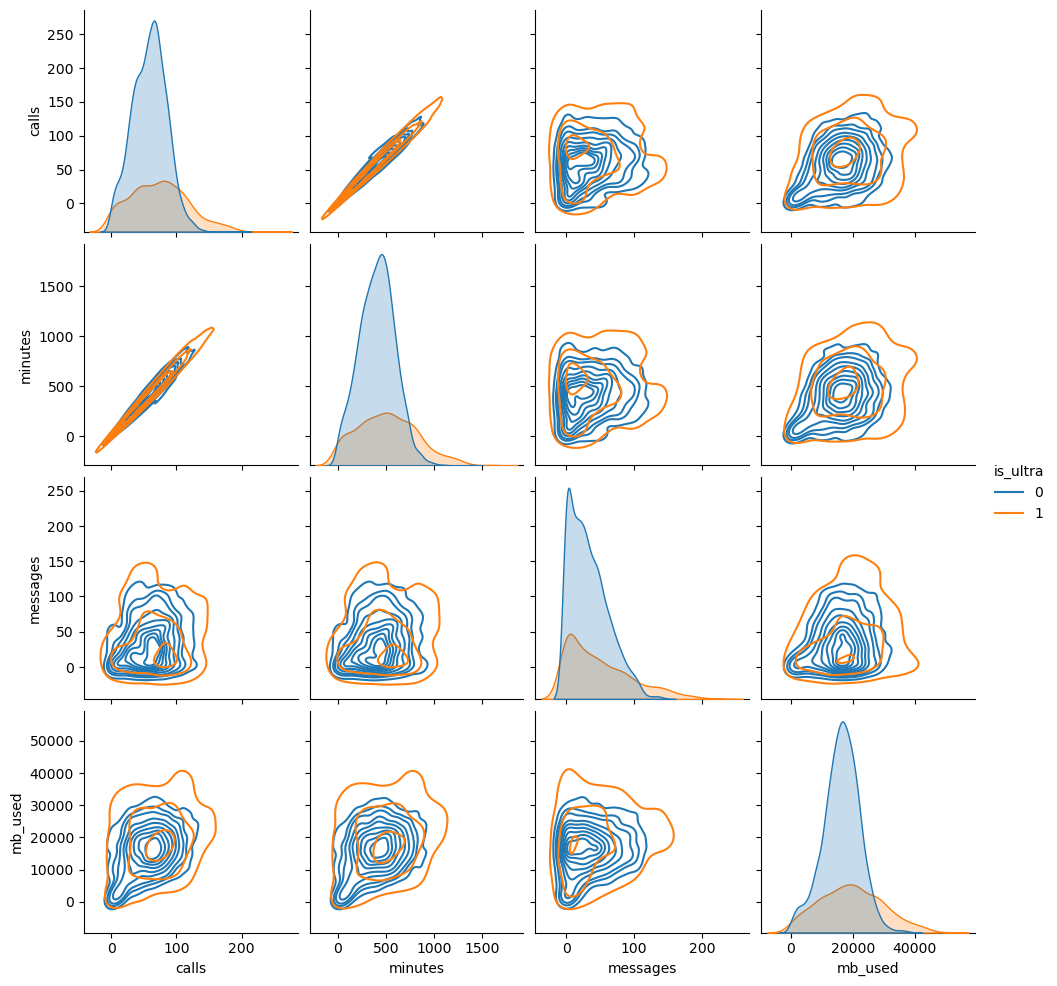

In [42]:
sns.pairplot(users, kind='kde', hue='is_ultra')

In [43]:
#duplicates
users.duplicated().sum()

0

In [44]:
#missing values
users.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [45]:
smart_portion = users[users['is_ultra'] == 0].shape[0] / users.shape[0]
ultra_portion = users[users['is_ultra'] == 1].shape[0] / users.shape[0]
print(f'Share of Smart users in dataset = {smart_portion:.1%}\n\
Share of Ultra users in dataset = {ultra_portion:.1%}')

Share of Smart users in dataset = 69.4%
Share of Ultra users in dataset = 30.6%


**Conclusion:**

1. **Preprocessing Scope**: Extensive preprocessing isn't necessary based on the project requirements.
    - No missing values are detected.
    - No obvious duplicates are detected. While potential duplicates might exist, their identification as duplicates lacks certainty.
    
    
2. **Data Imbalance**: The dataset comprises 3214 observations, with 985 for Ultra users and 2229 for Smart users, indicating a imbalance. 
3. **Usage Disparity**: Ultra users exhibit higher consumption across various traffic types compared to Smart users. However, the distribution of usage among Ultra users appears more dispersed. 
4. **Assessing Accuracy Expectations for User Classification**: Conversely, considering the absence of clear parameters distinguishing between Ultra and Smart users, anticipating a high accuracy level might be unrealistic. It's imperative to evaluate the model's performance against random guessing as a sanity check due to the lack of evident parameters segregating these user groups.
4. **Correlation Insight**: The number of `calls` and `minutes` of call display a strong correlation. Consequently, considering dropping one of these variables for model fitting might be necessary.

## Choosing model

In [46]:
# settings
RANDOM_STATE = 42
TEST_SIZE = 0.20
CROSS_VALIDATION = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### **All features**
#### Splitting data

In [47]:
X = users.drop(columns=['is_ultra'])  # Features (including both `calls` and `minutes`)
y = users['is_ultra']  # Target variable

# Assuming data is already loaded and split into features (X) and target variable (y)
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

#### Creating set of estimators

In [48]:
# Create pipelines with hyperparameters for different classifiers
pipelines = {
    'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression(random_state=RANDOM_STATE))]),
    'Decision Tree': Pipeline([('scaler', StandardScaler()), ('DT', DecisionTreeClassifier(random_state=RANDOM_STATE))]),
    'Naive Bayes': Pipeline([('scaler', StandardScaler()), ('NB', GaussianNB())]),
    'K-Nearest Neighbors': Pipeline([('scaler', StandardScaler()), ('KNN', KNeighborsClassifier())]),
    'Neural Network': Pipeline([('scaler', StandardScaler()), ('NN', MLPClassifier(random_state=RANDOM_STATE))]),
    'Random Forest': Pipeline([('scaler', StandardScaler()), ('RF', RandomForestClassifier(random_state=RANDOM_STATE))]),
    'SVM': Pipeline([('scaler', StandardScaler()), ('SVM', SVC(random_state=RANDOM_STATE))]),
    'AdaBoost': Pipeline([('scaler', StandardScaler()), ('Ada', AdaBoostClassifier(random_state=RANDOM_STATE))])
}
pipelines

{'Logistic Regression': Pipeline(steps=[('scaler', StandardScaler()),
                 ('LR', LogisticRegression(random_state=42))]),
 'Decision Tree': Pipeline(steps=[('scaler', StandardScaler()),
                 ('DT', DecisionTreeClassifier(random_state=42))]),
 'Naive Bayes': Pipeline(steps=[('scaler', StandardScaler()), ('NB', GaussianNB())]),
 'K-Nearest Neighbors': Pipeline(steps=[('scaler', StandardScaler()), ('KNN', KNeighborsClassifier())]),
 'Neural Network': Pipeline(steps=[('scaler', StandardScaler()),
                 ('NN', MLPClassifier(random_state=42))]),
 'Random Forest': Pipeline(steps=[('scaler', StandardScaler()),
                 ('RF', RandomForestClassifier(random_state=42))]),
 'SVM': Pipeline(steps=[('scaler', StandardScaler()), ('SVM', SVC(random_state=42))]),
 'AdaBoost': Pipeline(steps=[('scaler', StandardScaler()),
                 ('Ada', AdaBoostClassifier(random_state=42))])}

#### Creating set of hyperparametres for estimators

In [49]:
# Define hyperparameters grid for each classifier
param_grid = {
    'Logistic Regression': {
        'LR__C': [0.1, 1, 10],
        'LR__solver': ['liblinear', 'lbfgs']
    },
    'Decision Tree': {
        'DT__max_depth': [5, 10, 20],
        'DT__min_samples_split': [2, 5, 10]
    },
    'Naive Bayes': {},  # Naive Bayes doesn't have hyperparameters to tune
    'K-Nearest Neighbors': {
        'KNN__n_neighbors': [3, 5, 7, 9],
        'KNN__weights': ['uniform', 'distance']
    },
    'Neural Network': {
        'NN__hidden_layer_sizes': [(50, 30), (100, 50)],
        'NN__max_iter': [500, 1000]
    },
    'Random Forest': {
        'RF__n_estimators': [50, 100, 200],
        'RF__max_depth': [5, 10, 20]
    },
    'SVM': {
        'SVM__C': [0.1, 1, 10],
        'SVM__kernel': ['linear', 'rbf']
    },
    'AdaBoost': {
        'Ada__n_estimators': [50, 100, 200],
        'Ada__learning_rate': [0.1, 0.5, 1.0]
    }
}


#### Finding Best estimator

In [50]:
# Fit models using GridSearchCV and evaluate accuracy
best_estimators = {}
cv_results = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grid=param_grid[name], cv=CROSS_VALIDATION, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_estimators[name] = grid_search.best_estimator_
    cv_results[name] = grid_search.cv_results_
    y_pred = best_estimators[name].predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    y_train_pred = best_estimators[name].predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    print(f"{name}\nBest Accuracy on test set: {accuracy:.1%}\nBest Accuracy on train set: {accuracy_train:.1%}")
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print('---------------------------------')

Logistic Regression
Best Accuracy on test set: 76.0%
Best Accuracy on train set: 74.7%
Best Hyperparameters: {'LR__C': 0.1, 'LR__solver': 'liblinear'}
---------------------------------
Decision Tree
Best Accuracy on test set: 80.7%
Best Accuracy on train set: 81.4%
Best Hyperparameters: {'DT__max_depth': 5, 'DT__min_samples_split': 2}
---------------------------------
Naive Bayes
Best Accuracy on test set: 77.6%
Best Accuracy on train set: 78.6%
Best Hyperparameters: {}
---------------------------------
K-Nearest Neighbors
Best Accuracy on test set: 80.1%
Best Accuracy on train set: 100.0%
Best Hyperparameters: {'KNN__n_neighbors': 7, 'KNN__weights': 'distance'}
---------------------------------
Neural Network
Best Accuracy on test set: 81.2%
Best Accuracy on train set: 82.6%
Best Hyperparameters: {'NN__hidden_layer_sizes': (50, 30), 'NN__max_iter': 500}
---------------------------------
Random Forest
Best Accuracy on test set: 82.0%
Best Accuracy on train set: 88.6%
Best Hyperparamete

In [51]:
dummy_clf = Pipeline([('scaler', StandardScaler()), ('Dummy', DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE))])
dummy_clf.fit(X_train, y_train)
accuracy_dummy = dummy_clf.score(X_test, y_test)
accuracy_dummy_train = dummy_clf.score(X_train, y_train)
print(f"Accuracy of Dummy classifier on test set: {accuracy_dummy:.1%}\nAccuracy of Dummy classifier on train set: {accuracy_dummy_train:.1%}")

Accuracy of Dummy classifier on test set: 70.8%
Accuracy of Dummy classifier on train set: 69.0%


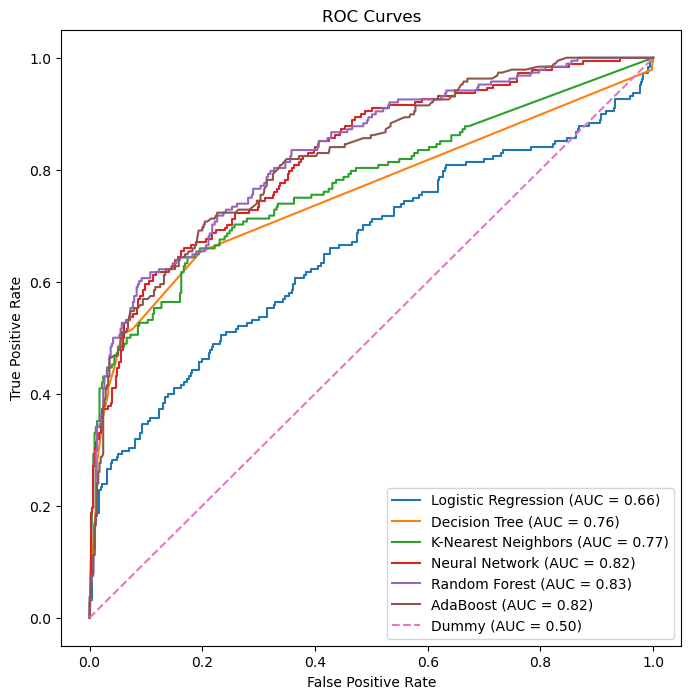

In [52]:
# Plot ROC curves for classifiers
plt.figure(figsize=(8, 8))

for name, estimator in best_estimators.items():
    if name in ['Naive Bayes', 'SVM']:  # do not have predict_proba
        continue
    y_score = estimator.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

y_score_dummy = dummy_clf.predict_proba(X_test)[:, 1]
fpr_d, tpr_d, _ = roc_curve(y_test, y_score_dummy)
roc_auc_dummy = auc(fpr_d, tpr_d) 
    
plt.plot(fpr_d, tpr_d, linestyle='--', label=f'Dummy (AUC = {roc_auc_dummy:.2f})')    
#plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

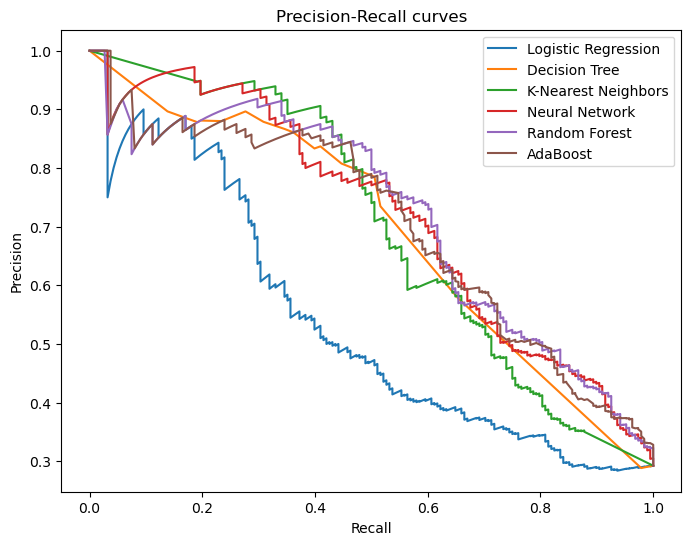

In [53]:
# Plot Precision-recall curves for classifiers
plt.figure(figsize=(8, 6))

for name, estimator in best_estimators.items():
    if name in ['Naive Bayes', 'SVM']:  # do not have predict_proba
        continue
    y_score = estimator.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.plot(recall, precision, label=f'{name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curves')
plt.legend()
plt.show()

#### Plotting time: fit and predict

Text(0.5, 1.0, 'Mean Fit Time for Classifiers')

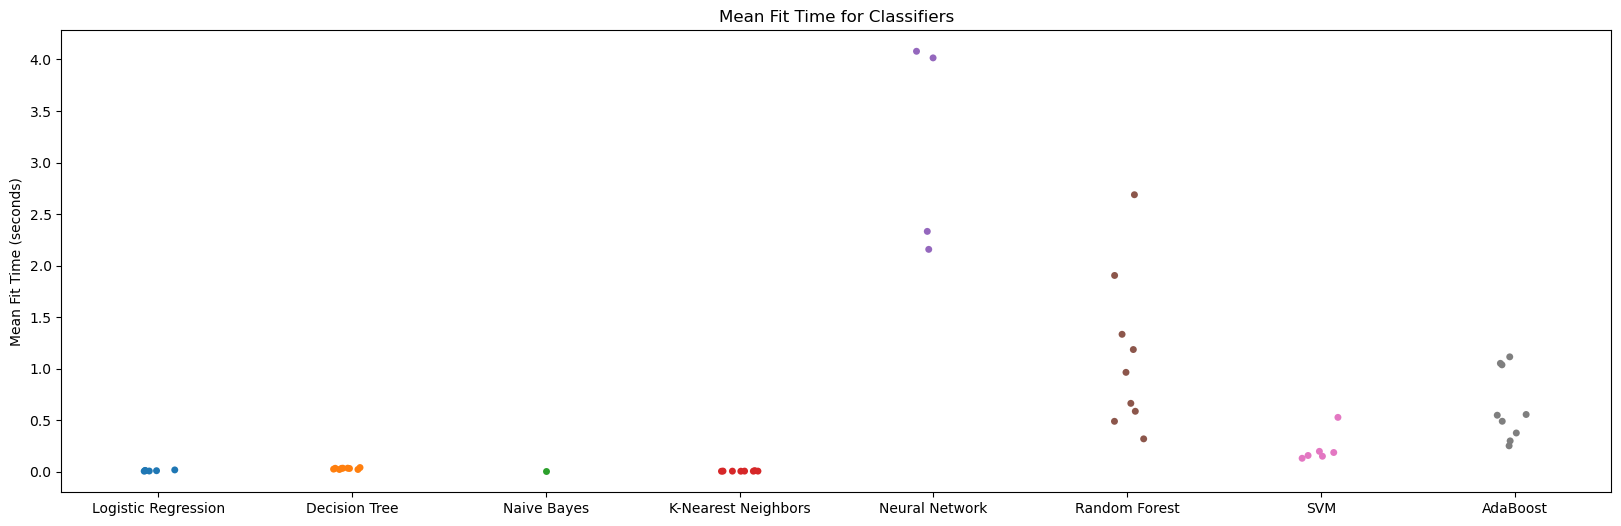

In [54]:
df = pd.DataFrame(cv_results)
fit_time = df.from_records(df.loc['mean_fit_time', :]).T
fit_time.columns = df.loc['mean_fit_time', :].index

plt.figure(figsize=(20, 6))
sns.stripplot(data=fit_time, jitter=True)
plt.ylabel('Mean Fit Time (seconds)')
plt.title('Mean Fit Time for Classifiers')

Text(0.5, 1.0, 'Mean Score Time for Classifiers')

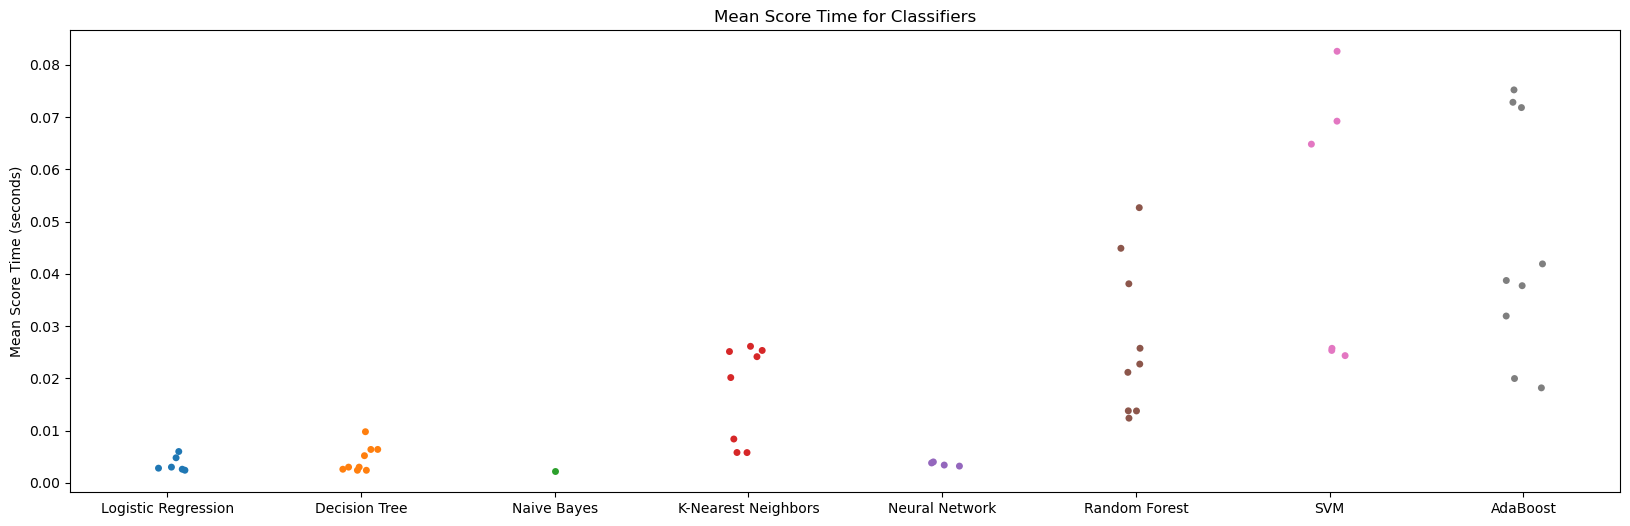

In [55]:
mean_score_time = df.from_records(df.loc['mean_score_time', :]).T
mean_score_time.columns = df.loc['mean_score_time', :].index

plt.figure(figsize=(20, 6))
sns.stripplot(data=mean_score_time, jitter=True)
plt.ylabel('Mean Score Time (seconds)')
plt.title('Mean Score Time for Classifiers')

**Conclusion:**

1. **Target Metric Clarification**: The primary metric we're targeting for this task is accuracy. All classifiers are better than random guess.
2. **Best Classifier Analysis - Random Forest**: Considering the dataset, the Random Forest classifier set with `max_depth=10` and `n_estimators=200` demonstrates its suitability:
    - It secures the highest score on both the test and train sets, with a moderate difference between the two (unlike the visibly overfitted KNN).
    - Additionally, it showcases superior ROC and Precision-Recall results.
    
    
3. **Consistency in Fitting Time**: Across all classifiers, the fitting times are quite similar, except for the Neural Network. The Neural Network, however, demands significantly more time for fitting without yielding substantial improvement.
4. **Prediction and Scoring Time Variance**: While the time taken for prediction and scoring fluctuates, it generally remains within acceptable levels for all classifiers, showcasing reasonable consistency.

### Features except `calls`
#### Splitting data

In [56]:
X_min = users.drop(columns=['is_ultra', 'calls'])  # Features (including both `calls` and `minutes`)
y_min = users['is_ultra']  # Target variable

# Assuming data is already loaded and split into features (X) and target variable (y)
# Splitting the dataset into train and test sets
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X_min, y_min, test_size=TEST_SIZE, random_state=RANDOM_STATE)

#### Finding Best estimator

In [57]:
# Fit models using GridSearchCV and evaluate accuracy
best_estimators_min = {}
cv_results_min = {}
for name, pipeline in pipelines.items():
    grid_search_min = GridSearchCV(pipeline, param_grid=param_grid[name], cv=CROSS_VALIDATION, scoring='accuracy')
    grid_search_min.fit(X_train_min, y_train_min)
    best_estimators_min[name] = grid_search_min.best_estimator_
    cv_results_min[name] = grid_search_min.cv_results_
    y_pred_min = best_estimators_min[name].predict(X_test_min)
    accuracy = accuracy_score(y_test_min, y_pred_min)
    y_train_pred_min = best_estimators_min[name].predict(X_train_min)
    accuracy_train = accuracy_score(y_train_min, y_train_pred_min)
    print(f"{name}\nBest Accuracy on test set: {accuracy:.1%}\nBest Accuracy on train set: {accuracy_train:.1%}")
    print(f"Best Hyperparameters: {grid_search_min.best_params_}")
    print('---------------------------------')

Logistic Regression
Best Accuracy on test set: 75.9%
Best Accuracy on train set: 74.5%
Best Hyperparameters: {'LR__C': 0.1, 'LR__solver': 'lbfgs'}
---------------------------------
Decision Tree
Best Accuracy on test set: 79.0%
Best Accuracy on train set: 81.4%
Best Hyperparameters: {'DT__max_depth': 5, 'DT__min_samples_split': 2}
---------------------------------
Naive Bayes
Best Accuracy on test set: 77.1%
Best Accuracy on train set: 77.4%
Best Hyperparameters: {}
---------------------------------
K-Nearest Neighbors
Best Accuracy on test set: 80.6%
Best Accuracy on train set: 82.2%
Best Hyperparameters: {'KNN__n_neighbors': 9, 'KNN__weights': 'uniform'}
---------------------------------
Neural Network
Best Accuracy on test set: 80.9%
Best Accuracy on train set: 82.5%
Best Hyperparameters: {'NN__hidden_layer_sizes': (50, 30), 'NN__max_iter': 500}
---------------------------------
Random Forest
Best Accuracy on test set: 81.8%
Best Accuracy on train set: 88.1%
Best Hyperparameters: {'

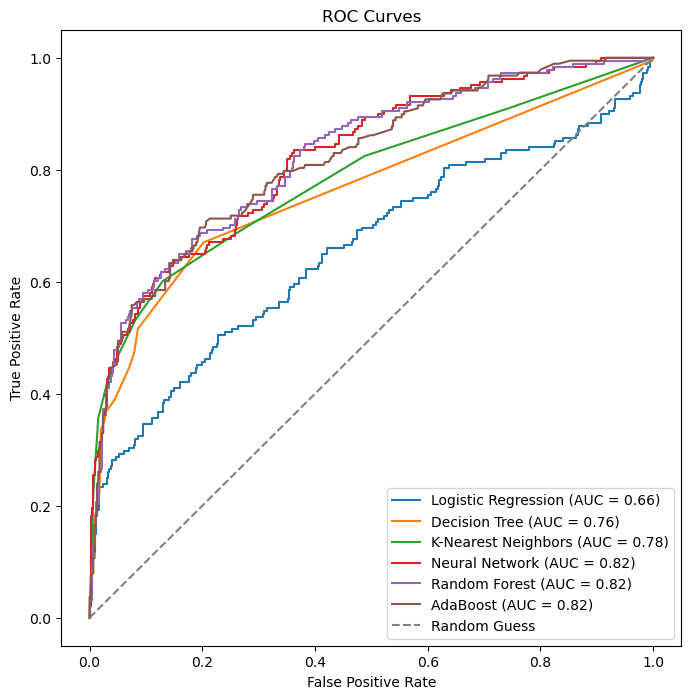

In [58]:
# Plot ROC curves for classifiers
plt.figure(figsize=(8, 8))

for name, estimator in best_estimators_min.items():
    if name in ['Naive Bayes', 'SVM']:  # do not have predict_proba
        continue
    y_score_min = estimator.predict_proba(X_test_min)[:, 1]
    fpr_min, tpr_min, _ = roc_curve(y_test_min, y_score_min)
    roc_auc_min = auc(fpr_min, tpr_min)
    plt.plot(fpr_min, tpr_min, label=f'{name} (AUC = {roc_auc_min:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

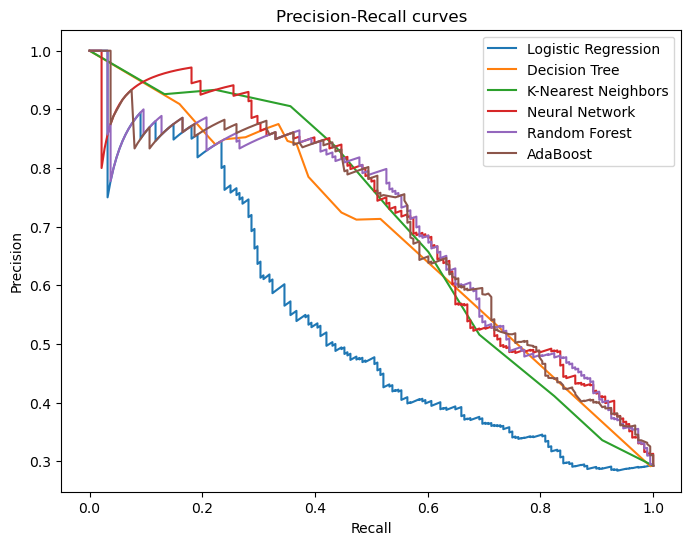

In [59]:
# Plot Precision-recall curves for classifiers
plt.figure(figsize=(8, 6))

for name, estimator in best_estimators_min.items():
    if name in ['Naive Bayes', 'SVM']:  # do not have predict_proba
        continue
    y_score_min = estimator.predict_proba(X_test_min)[:, 1]
    precision_min, recall_min, _ = precision_recall_curve(y_test_min, y_score_min)
    plt.plot(recall_min, precision_min, label=f'{name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curves')
plt.legend()
plt.show()

#### Plotting time: fit and predict

Text(0.5, 1.0, 'Mean Fit Time for Classifiers')

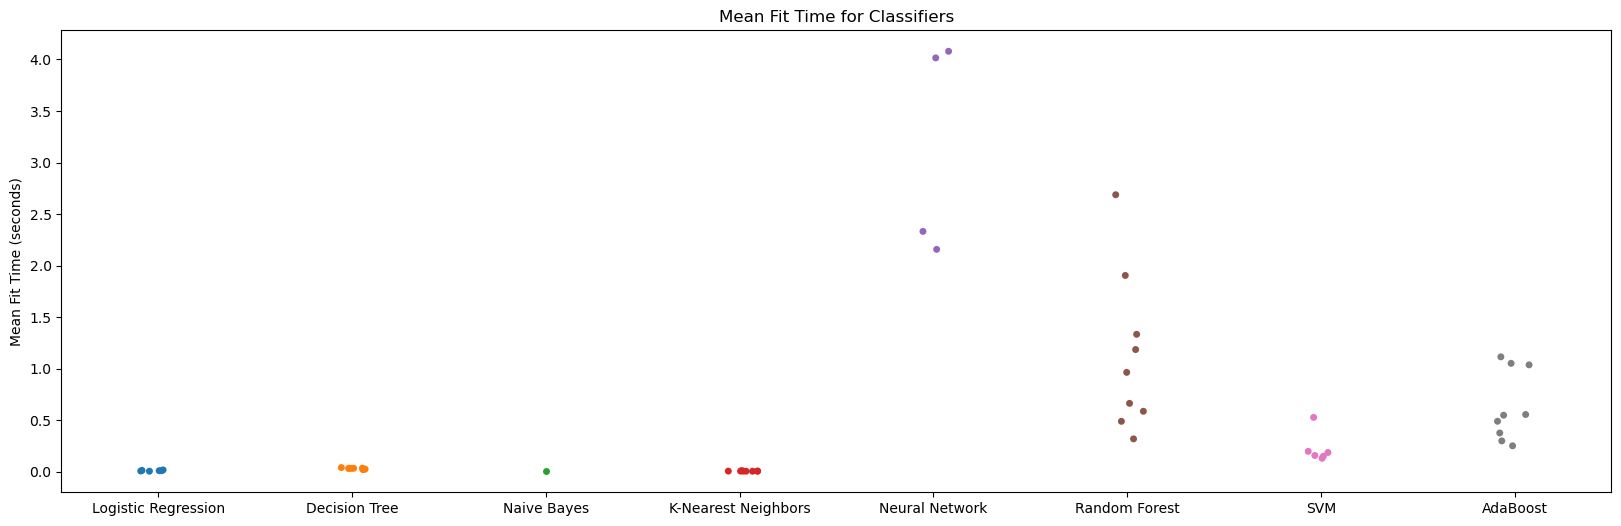

In [60]:
df_min = pd.DataFrame(cv_results_min)
fit_time_min = df_min.from_records(df.loc['mean_fit_time', :]).T
fit_time_min.columns = df_min.loc['mean_fit_time', :].index

plt.figure(figsize=(20, 6))
sns.stripplot(data=fit_time_min, jitter=True)
plt.ylabel('Mean Fit Time (seconds)')
plt.title('Mean Fit Time for Classifiers')

Text(0.5, 1.0, 'Mean Score Time for Classifiers')

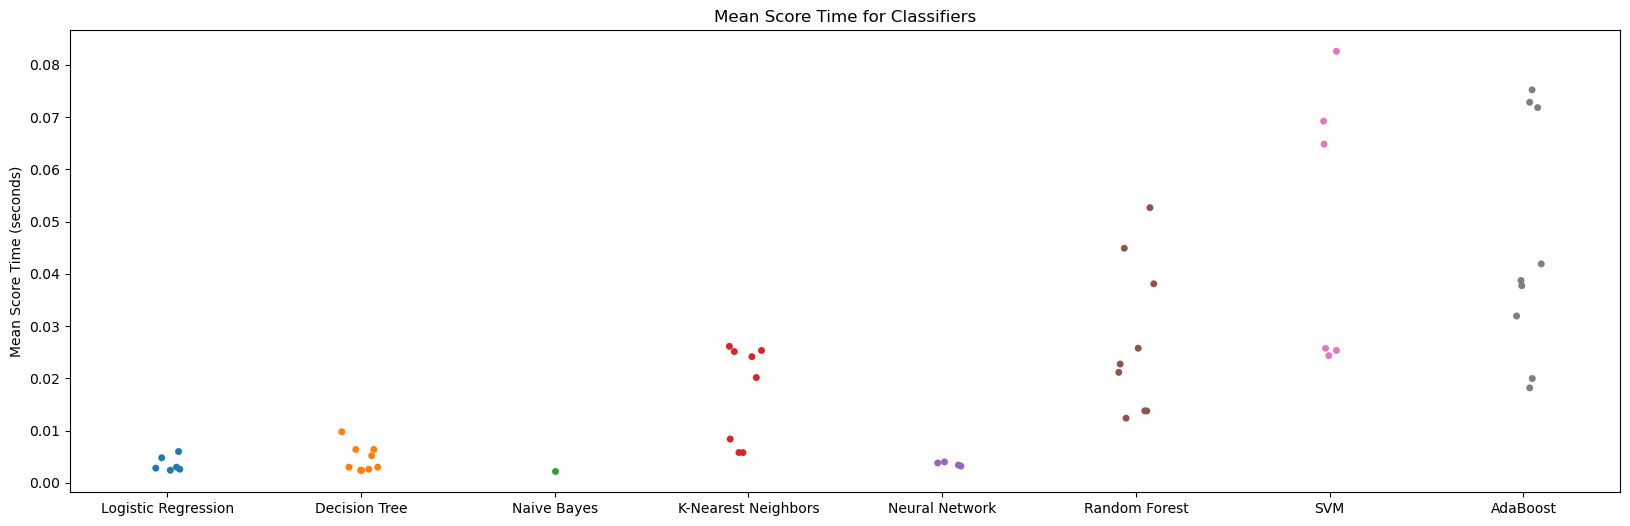

In [61]:
mean_score_time_min = df_min.from_records(df.loc['mean_score_time', :]).T
mean_score_time_min.columns = df_min.loc['mean_score_time', :].index

plt.figure(figsize=(20, 6))
sns.stripplot(data=mean_score_time_min, jitter=True)
plt.ylabel('Mean Score Time (seconds)')
plt.title('Mean Score Time for Classifiers')

**Conclusion:**

**Exclusion of `calls` Feature**: Upon dropping the `calls` feature, no significant value is added to the problem:
- The optimal estimator remains unchanged – the Random Forest classifier with `max_depth=10` and `n_estimators=200`.
- Metrics exhibit a slight decrease, rather than improvement.
- There's no observed enhancement in fitting and scoring times.

### Final result
**Optimal Estimator Verdict**: the Random Forest classifier set with `max_depth=10` and `n_estimators=200` continues to stand out as the best estimator based on the initial dataset due to:
- Achieving the highest accuracy of 82.0% on the test set, surpassing other models and demonstrating consistent performance higher than random guess, albeit not substantially higher (about 12pp).
- Demonstrating superior ROC and precision-recall metrics, underlining its robustness in classification performance.
- Exhibiting reasonable time requirements for both fitting and prediction, ensuring efficiency without compromising effectiveness.

## Feature selection as part of cross-validation

*less number of estimators to save time*

In [34]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


In [35]:
estimators_RFECV = {
    'Perceptron': Perceptron(random_state=RANDOM_STATE),
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
#     'Naive Bayes': GaussianNB(),
#     'K-Nearest Neighbors': KNeighborsClassifier(),
#     'Neural Network': MLPClassifier(random_state=RANDOM_STATE),
    'Random Forest':RandomForestClassifier(random_state=RANDOM_STATE),
#     'SVM': SVC(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE)
}
estimators_RFECV

{'Perceptron': Perceptron(random_state=42),
 'Logistic Regression': LogisticRegression(random_state=42),
 'Decision Tree': DecisionTreeClassifier(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'AdaBoost': AdaBoostClassifier(random_state=42)}

In [36]:
# Define hyperparameters grid for each classifier
param_grid_RFECV = {
    'Perceptron': {
        'estimator__penalty': ['l2', 'l1', 'elasticnet']
    },
    'Logistic Regression': {
        'estimator__C': [0.1, 1, 10],
        'estimator__solver': ['liblinear', 'lbfgs']
    },
    'Decision Tree': {
        'estimator__max_depth': [5, 10, 20],
        'estimator__min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__max_depth': [5, 10, 20]
    },
    'AdaBoost': {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__learning_rate': [0.1, 0.5, 1.0]
    }
}
param_grid_RFECV

{'Perceptron': {'estimator__penalty': ['l2', 'l1', 'elasticnet']},
 'Logistic Regression': {'estimator__C': [0.1, 1, 10],
  'estimator__solver': ['liblinear', 'lbfgs']},
 'Decision Tree': {'estimator__max_depth': [5, 10, 20],
  'estimator__min_samples_split': [2, 5, 10]},
 'Random Forest': {'estimator__n_estimators': [50, 100, 200],
  'estimator__max_depth': [5, 10, 20]},
 'AdaBoost': {'estimator__n_estimators': [50, 100, 200],
  'estimator__learning_rate': [0.1, 0.5, 1.0]}}

In [38]:
best_estimators_RFECV = {}
cv_results_RFECV = {}
selected_features_RFECV={}
for name, estimator in estimators_RFECV.items():
    # Creating a pipeline with scaler, feature selection, and estimator
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Adding a scaler
        ('feature_selection', RFECV(estimator=estimator, cv=inner_cv)),
        ('estimator', clone(estimator))
    ])
       
    grid_search = GridSearchCV(pipeline, param_grid=param_grid_RFECV[name], cv=outer_cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_estimators_RFECV[name] = grid_search.best_estimator_
    cv_results_RFECV[name] = grid_search.cv_results_
    selected_features_RFECV[name] = grid_search.best_estimator_.named_steps['feature_selection'].get_support()
    y_pred = best_estimators_RFECV[name].predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    y_train_pred = best_estimators_RFECV[name].predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    print(f"{name}\nBest Accuracy on test set: {accuracy:.1%}\nBest Accuracy on train set: {accuracy_train:.1%}")
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Best features: {X_train.columns[grid_search.best_estimator_.named_steps['feature_selection'].get_support()].values}")
    print('---------------------------------')

Perceptron
Best Accuracy on test set: 74.5%
Best Accuracy on train set: 74.0%
Best Hyperparameters: {'estimator__penalty': 'elasticnet'}
Best features: ['minutes' 'mb_used']
---------------------------------
Logistic Regression
Best Accuracy on test set: 76.0%
Best Accuracy on train set: 74.7%
Best Hyperparameters: {'estimator__C': 0.1, 'estimator__solver': 'liblinear'}
Best features: ['minutes' 'messages' 'mb_used']
---------------------------------
Decision Tree
Best Accuracy on test set: 80.9%
Best Accuracy on train set: 86.3%
Best Hyperparameters: {'estimator__max_depth': 10, 'estimator__min_samples_split': 10}
Best features: ['calls' 'minutes' 'messages' 'mb_used']
---------------------------------
Random Forest
Best Accuracy on test set: 82.0%
Best Accuracy on train set: 88.6%
Best Hyperparameters: {'estimator__max_depth': 10, 'estimator__n_estimators': 200}
Best features: ['calls' 'minutes' 'messages' 'mb_used']
---------------------------------
AdaBoost
Best Accuracy on test se

Conclusion: this approach leads to the same result